# Introduction
Customer churn remains one of the biggest concerns for telecom providers, directly impacting revenue and growth. This analysis uses the Cell2Cell Churn dataset to explore key drivers behind customer attrition and develop a predictive model to identify at-risk users.
The dataset includes various features ranging from service usage statistics (like minutes used and call frequency), customer demographics, and contract details. 


In [119]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder


### Data Loading

In [120]:
# Load Dataset
df = pd.read_csv("cell2celltrain.csv.zip")
print("Dataset loaded successfully. Displaying head and info:")
df.head()

Dataset loaded successfully. Displaying head and info:


,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


In [121]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 51047 non-null  int64  
 1   Churn                      51047 non-null  object 
 2   MonthlyRevenue             50891 non-null  float64
 3   MonthlyMinutes             50891 non-null  float64
 4   TotalRecurringCharge       50891 non-null  float64
 5   DirectorAssistedCalls      50891 non-null  float64
 6   OverageMinutes             50891 non-null  float64
 7   RoamingCalls               50891 non-null  float64
 8   PercChangeMinutes          50680 non-null  float64
 9   PercChangeRevenues         50680 non-null  float64
 10  DroppedCalls               51047 non-null  float64
 11  BlockedCalls               51047 non-null  float64
 12  UnansweredCalls            51047 non-null  float64
 13  CustomerCareCalls          51047 non-null  flo

### Data Preprocessing

In [122]:
# Handling Missing value

df.dropna()

print(df.isnull().sum()[df.isnull().sum() > 0])

MonthlyRevenue           156
MonthlyMinutes           156
TotalRecurringCharge     156
DirectorAssistedCalls    156
OverageMinutes           156
RoamingCalls             156
PercChangeMinutes        367
PercChangeRevenues       367
ServiceArea               24
Handsets                   1
HandsetModels              1
CurrentEquipmentDays       1
AgeHH1                   909
AgeHH2                   909
dtype: int64


In [123]:
df_encoded = pd.get_dummies(df, drop_first=True)

In [124]:
if 'ServiceArea' in df.columns:
    df.drop(columns=['ServiceArea'], inplace=True)
    print("Dropped 'ServiceArea' column.")

Dropped 'ServiceArea' column.


In [125]:
# Handling Missing Value for numarical columns by filling with the median
numerical_cols = df.select_dtypes(include=np.number).columns

for col in numerical_cols:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Filled missing values in numerical column '{col}' with median: {median_val}")

Filled missing values in numerical column 'MonthlyRevenue' with median: 48.46
Filled missing values in numerical column 'MonthlyMinutes' with median: 366.0
Filled missing values in numerical column 'TotalRecurringCharge' with median: 45.0
Filled missing values in numerical column 'DirectorAssistedCalls' with median: 0.25
Filled missing values in numerical column 'OverageMinutes' with median: 3.0
Filled missing values in numerical column 'RoamingCalls' with median: 0.0
Filled missing values in numerical column 'PercChangeMinutes' with median: -5.0
Filled missing values in numerical column 'PercChangeRevenues' with median: -0.3
Filled missing values in numerical column 'Handsets' with median: 1.0
Filled missing values in numerical column 'HandsetModels' with median: 1.0
Filled missing values in numerical column 'CurrentEquipmentDays' with median: 329.0
Filled missing values in numerical column 'AgeHH1' with median: 36.0
Filled missing values in numerical column 'AgeHH2' with median: 0.0


C:\Users\Maheswaran\AppData\Local\Temp\ipykernel_18904\2441227486.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
C:\Users\Maheswaran\AppData\Local\Temp\ipykernel_18904\2441227486.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

In [126]:
# Handling Missing Values with categorical columns by filling with the mode
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"Filled missing values in categorical column '{col}' with mode: {mode_val}")   

In [127]:
print("\nMissing values after processing:")
print(df.isnull().sum()[df.isnull().sum() > 0])
if df.isnull().sum().sum() == 0:
    print("No missing values remaining in the dataset.")


Missing values after processing:
Series([], dtype: int64)
No missing values remaining in the dataset.


In [128]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (35732, 56)
Shape of X_test: (15315, 56)
Shape of y_train: (35732,)
Shape of y_test: (15315,)


### Target Variable

In [129]:
# Convert 'Churn' target variable to numerical format (Yes: 1, No: 0)
# This is necessary for machine learning models.
if 'Churn' in df.columns:
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
    print("Converted 'Churn' column to numerical (Yes=1, No=0).")

Converted 'Churn' column to numerical (Yes=1, No=0).


In [130]:
print("categorical features:")
for column in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    print(f"column: '{column}'")

categorical features:
column: 'ChildrenInHH'
column: 'HandsetRefurbished'
column: 'HandsetWebCapable'
column: 'TruckOwner'
column: 'RVOwner'
column: 'Homeownership'
column: 'BuysViaMailOrder'
column: 'RespondsToMailOffers'
column: 'OptOutMailings'
column: 'NonUSTravel'
column: 'OwnsComputer'
column: 'HasCreditCard'
column: 'NewCellphoneUser'
column: 'NotNewCellphoneUser'
column: 'OwnsMotorcycle'
column: 'HandsetPrice'
column: 'MadeCallToRetentionTeam'
column: 'CreditRating'
column: 'PrizmCode'
column: 'Occupation'
column: 'MaritalStatus'


In [131]:
# Target Variable is Churn
X = df.drop('Churn', axis=1)
y = df['Churn']

### Exploratory Data Analysis

C:\Users\Maheswaran\AppData\Local\Temp\ipykernel_18904\2074176276.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='viridis')


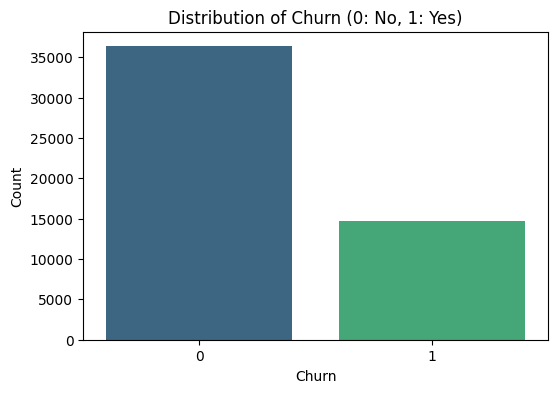

In [132]:
# Ploting Target Variable "Churn" to Understand to class imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df, palette='viridis')
plt.title('Distribution of Churn (0: No, 1: Yes)')
plt.xlabel('Churn')
plt.ylabel('Count') 
plt.show()
# Here "0" represents "No Churn" and "1" represents "Churn"

C:\Users\Maheswaran\AppData\Local\Temp\ipykernel_18904\2900268457.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df['MonthlyRevenue'], kde=True, palette='viridis')


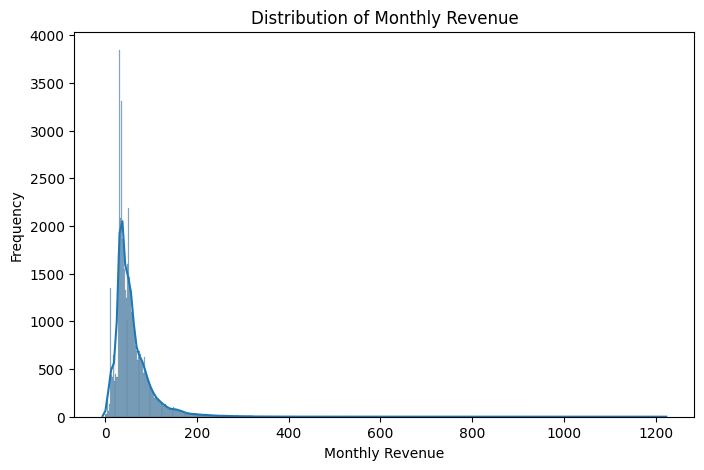

In [133]:
# Ploting "MonthlyRevenue" to understand the spread of revenue among customers
plt.figure(figsize=(8, 5))
sns.histplot(df['MonthlyRevenue'], kde=True, palette='viridis')
plt.title('Distribution of Monthly Revenue')
plt.xlabel('Monthly Revenue')
plt.ylabel('Frequency')
plt.show()

### Randomforest Classifier

In [134]:
# --- Random Forest Classifier ---
print("--- Training Random Forest Classifier ---")

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
print("Random Forest model trained.")

--- Training Random Forest Classifier ---
Random Forest model trained.


In [135]:
 # Predict on the test set
y_pred_rf = rf_model.predict(X_test) # Predicted classes (0 or 1)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1] 

In [136]:
# Evaluate Random Forest model
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.97      0.83     10901
           1       0.56      0.08      0.14      4414

    accuracy                           0.72     15315
   macro avg       0.64      0.53      0.49     15315
weighted avg       0.68      0.72      0.63     15315



In [137]:
# Calculate ROC AUC Score for Random Forest
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"Random Forest ROC AUC Score: {roc_auc_rf:.4f}")

Random Forest ROC AUC Score: 0.6503


### Navie Bayes Classifier

In [138]:
# --- Naive Bayes Classifier (GaussianNB) ---
print("--- Training Naive Bayes Classifier (GaussianNB) ---")
# GaussianNB is suitable for continuous data, assuming a Gaussian distribution.
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
print("Naive Bayes model trained.")

--- Training Naive Bayes Classifier (GaussianNB) ---
Naive Bayes model trained.


In [139]:
# Predict on the test set
y_pred_nb = nb_model.predict(X_test)
y_prob_nb = nb_model.predict_proba(X_test)[:, 1]

In [140]:
# Evaluate Naive Bayes model
print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.73     10901
           1       0.35      0.38      0.36      4414

    accuracy                           0.62     15315
   macro avg       0.55      0.55      0.55     15315
weighted avg       0.63      0.62      0.62     15315



In [141]:
# Calculate ROC AUC Score for Naive Bayes
roc_auc_nb = roc_auc_score(y_test, y_prob_nb)
print(f"Naive Bayes ROC AUC Score: {roc_auc_nb:.4f}")

Naive Bayes ROC AUC Score: 0.5736


### Model comparision

In [142]:
# --- Model Comparison ---
print("--- Model Comparison ---")
print(f"Random Forest ROC AUC: {roc_auc_rf:.4f}")
print(f"Naive Bayes ROC AUC: {roc_auc_nb:.4f}")

--- Model Comparison ---
Random Forest ROC AUC: 0.6503
Naive Bayes ROC AUC: 0.5736


In [143]:
# Calculate False Positive Rate (fpr) and True Positive Rate (tpr) for both models
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)

### Ploting ROC Curve

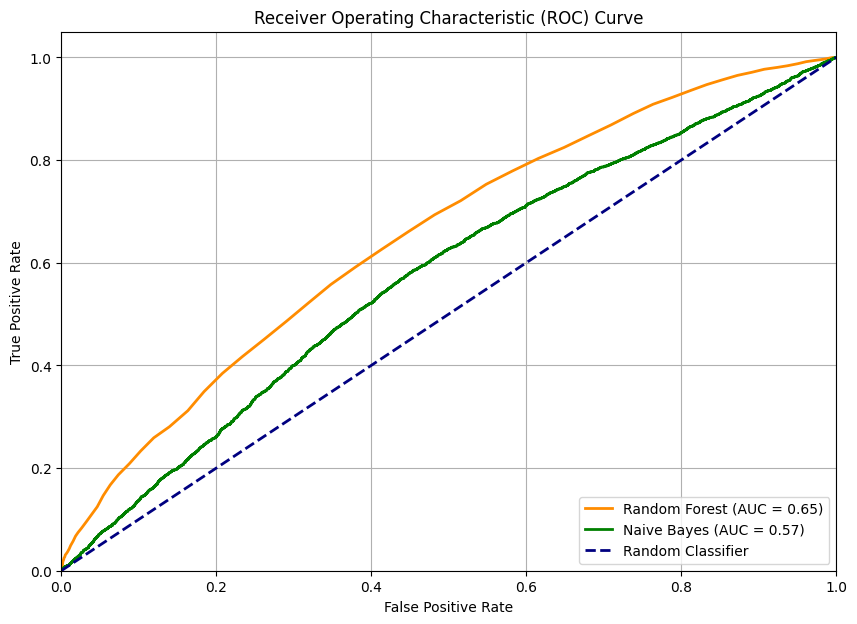

In [144]:
# Plot Random Forest ROC curve
plt.figure(figsize=(10, 7))   
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot(fpr_nb, tpr_nb, color='green', lw=2, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [145]:
# --- Prediction of test scores (probabilities) ---
print("\nActual Churn values (first 10):")
print(y_test.head(10).values)



Actual Churn values (first 10):
[0 0 0 0 0 0 0 1 1 0]


In [146]:
print("\nRandom Forest Predicted Churn probabilities (first 10):")
print(y_prob_rf[:10])

print("\nNaive Bayes Predicted Churn probabilities (first 10):")
print(y_prob_nb[:10])


Random Forest Predicted Churn probabilities (first 10):
[0.32 0.16 0.18 0.41 0.11 0.15 0.46 0.14 0.51 0.16]

Naive Bayes Predicted Churn probabilities (first 10):
[4.91448981e-01 2.41185563e-01 3.24884872e-01 6.10849623e-01
 4.06075727e-01 3.69694640e-01 6.38757483e-01 5.28014346e-01
 5.25469769e-01 6.24069099e-04]


### Model Tuning using GridSearchCV (Random Forest Classifier)

In [147]:
# Hyperparameter Tuning (Random Forest Classifier)
from sklearn.model_selection import GridSearchCV
param_grid_small_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2] 
}

grid_search_small_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                                     param_grid=param_grid_small_rf,
                                     cv=3, 
                                     scoring='roc_auc',
                                     n_jobs=-1,
                                     verbose=2)

grid_search_small_rf.fit(X_train, y_train)

grid_search_small_rf.best_params_

print(f"{grid_search_small_rf.best_score_:.4f}")

best_rf_model_tuned = grid_search_small_rf.best_estimator_
print(f"Best Estimaters:", best_rf_model_tuned)
print("\nStored the best tuned Random Forest model.")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
0.6663
Best Estimaters: RandomForestClassifier(max_depth=10, min_samples_leaf=2, random_state=42)

Stored the best tuned Random Forest model.


### Visalize GridSearchCV

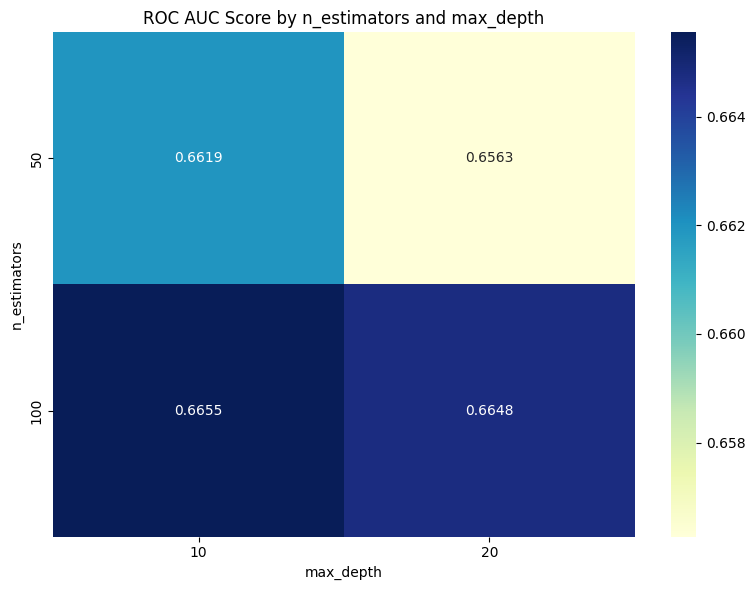

In [148]:
# Visalize the GridSearchCV after the Predicted ROCAUC Score
results = pd.DataFrame(grid_search_small_rf.cv_results_)

pivot_table = results.pivot_table(
    values='mean_test_score',
    index='param_n_estimators',
    columns='param_max_depth'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("ROC AUC Score by n_estimators and max_depth")
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.tight_layout()
plt.show()

### Tuning navie Bayes Classifier

In [149]:
# Hyperparameter Tuning (Naive Bayes Classifier)
from sklearn.naive_bayes import GaussianNB

# Define the parameter grid for NB
param_grid_nb = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

grid_search_nb = GridSearchCV(estimator=GaussianNB(),
                              param_grid=param_grid_nb,
                              cv=3,
                              scoring='roc_auc', 
                              n_jobs=-1, 
                              verbose=2) 

grid_search_nb.fit(X_train, y_train)

grid_search_nb.best_params_

print("\nBest ROC AUC score for Naive Bayes:")
print(f"{grid_search_nb.best_score_:.4f}")

best_nb_model = grid_search_nb.best_estimator_
print("\nStored the best Naive Bayes model.")

Fitting 3 folds for each of 100 candidates, totalling 300 fits

Best ROC AUC score for Naive Bayes:
0.5745

Stored the best Naive Bayes model.


### Ploting Navie Bayes

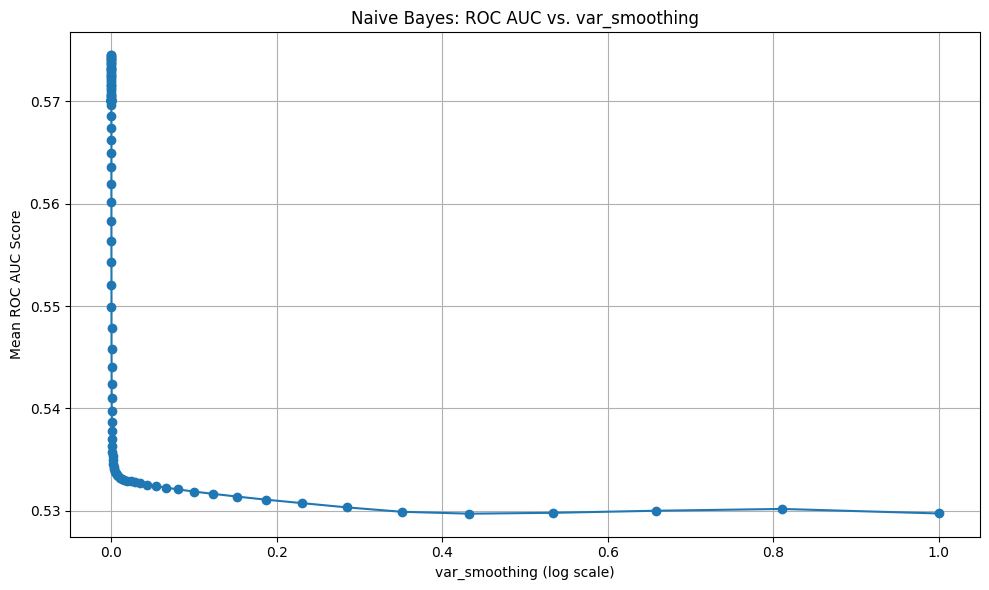

In [150]:
# Visuvalize the Naive Bayes after the Predicting ROC AUC Score 
nb_results = pd.DataFrame(grid_search_nb.cv_results_)

nb_results = nb_results.sort_values(by="param_var_smoothing")

plt.figure(figsize=(10, 6))
plt.plot(nb_results["param_var_smoothing"], nb_results["mean_test_score"], marker='o', linestyle='-')
plt.title("Naive Bayes: ROC AUC vs. var_smoothing")
plt.xlabel("var_smoothing (log scale)")
plt.ylabel("Mean ROC AUC Score")
plt.grid(True)
plt.tight_layout()
plt.show()

## Cross Validation

In [151]:
# Cross Validation
from sklearn.model_selection import cross_val_score

best_rf_params = grid_search_small_rf.best_params_
print(best_rf_params)

best_rf_params = {'bootstrap': True,
    'max_depth': 20,
    'min_samples_leaf': 2,
    'min_samples_split': 5,
    'n_estimators': 100
    }
print(best_rf_params)

tuned_rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, **best_rf_params)

cv_scores_rf = cross_val_score(tuned_rf_model, X, y, cv=5, scoring='roc_auc', n_jobs=-1)

print(f"\nTuned Random Forest Score: {cv_scores_rf}")
print(f"\nMean ROC AUC Score: {cv_scores_rf.mean():.4f}")
print(f"\nStandard Deviation Score: {cv_scores_rf.std():.4f}")

best_nb_params = grid_search_nb.best_params_
print("\nUsing best hyperparameters for Naive Bayes found by Grid Search:")
print(best_nb_params)

best_nb_params = {'var_smoothing': 1e-09}
print("\nGrid Search for Naive Bayes:", best_nb_params)

tuned_nb_model = GaussianNB(**best_nb_params)

print("\nCross-validation for Tuned Naive Bayes model...")
cv_scores_nb = cross_val_score(tuned_nb_model, X, y, cv=5, scoring='roc_auc', n_jobs=-1)

print(f"\nTuned Naive Bayes Cross-Validation ROC AUC Scores: {cv_scores_nb}")
print(f"\nMean ROC AUC (Tuned Naive Bayes): {cv_scores_nb.mean():.4f}")
print(f"\nStandard Deviation of ROC AUC (Tuned Naive Bayes): {cv_scores_nb.std():.4f}")


{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
{'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Tuned Random Forest Score: [0.59556588 0.61580714 0.4955158  0.33083713 0.63326739]

Mean ROC AUC Score: 0.5342

Standard Deviation Score: 0.1123

Using best hyperparameters for Naive Bayes found by Grid Search:
{'var_smoothing': np.float64(1.873817422860383e-06)}

Grid Search for Naive Bayes: {'var_smoothing': 1e-09}

Cross-validation for Tuned Naive Bayes model...

Tuned Naive Bayes Cross-Validation ROC AUC Scores: [0.58092669 0.56259781 0.55229965 0.57239227 0.57851474]

Mean ROC AUC (Tuned Naive Bayes): 0.5693

Standard Deviation of ROC AUC (Tuned Naive Bayes): 0.0106


In [152]:
# Visuvalize for Cross Validation
# Create DataFrames for easier plotting
cv_rf_df = pd.DataFrame({'Model': 'Tuned Random Forest', 'ROC AUC': cv_scores_rf})
cv_nb_df = pd.DataFrame({'Model': 'Tuned Naive Bayes', 'ROC AUC': cv_scores_nb})

cv_results_df = pd.concat([cv_rf_df, cv_nb_df])

C:\Users\Maheswaran\AppData\Local\Temp\ipykernel_18904\1042129106.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='ROC AUC', data=cv_results_df, palette='viridis')


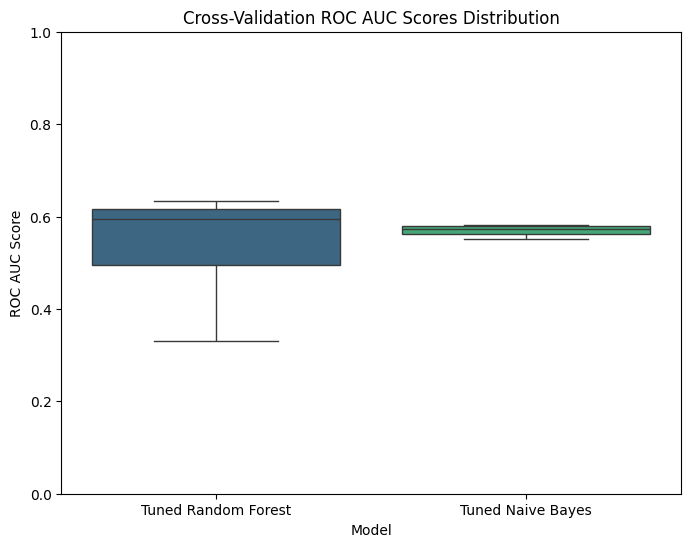

In [153]:
# Visuvalize the distribution of scpres across folds
plt.figure(figsize=(8, 6))
sns.boxplot(x='Model', y='ROC AUC', data=cv_results_df, palette='viridis')
plt.title('Cross-Validation ROC AUC Scores Distribution')
plt.xlabel('Model')
plt.ylabel('ROC AUC Score')
plt.ylim(0, 1)
plt.show()

C:\Users\Maheswaran\AppData\Local\Temp\ipykernel_18904\4076005509.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='Model', y='ROC AUC', data=cv_results_df, jitter=True, palette='viridis', s=8)


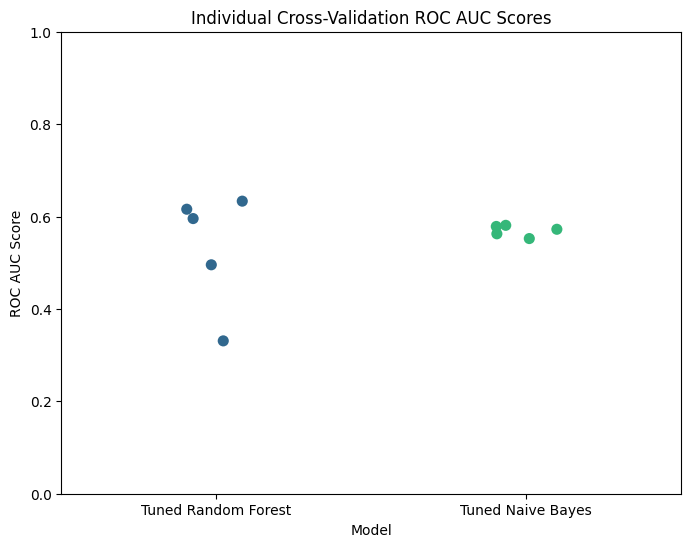

In [154]:
# Visuvalizing Individual Scores
plt.figure(figsize=(8, 6))
sns.stripplot(x='Model', y='ROC AUC', data=cv_results_df, jitter=True, palette='viridis', s=8)
plt.title('Individual Cross-Validation ROC AUC Scores')
plt.xlabel('Model')
plt.ylabel('ROC AUC Score')
plt.ylim(0, 1)
plt.show()

### Feature Importance

In [155]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance on the test set
result = permutation_importance(
    best_rf_model_tuned, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc'
)

# Store the results in a DataFrame
permutation_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
})

# Sort by mean importance
permutation_importance_df = permutation_importance_df.sort_values(by='importance_mean', ascending=False)

# Display the top N features
print("\nTop 15 Permutation Importances (Random Forest):")
display(permutation_importance_df.head(15))


Top 15 Permutation Importances (Random Forest):


,feature,importance_mean,importance_std
27,CurrentEquipmentDays,0.048052,0.002980
22,MonthsInService,0.017526,0.001555
7,PercChangeMinutes,0.016199,0.000938
3,TotalRecurringCharge,0.008890,0.001035
2,MonthlyMinutes,0.008497,0.001161
0,CustomerID,0.005207,0.000827
5,OverageMinutes,0.004777,0.001260
52,CreditRating,0.003022,0.000524
8,PercChangeRevenues,0.002923,0.000406
42,RetentionCalls,0.002592,0.000437


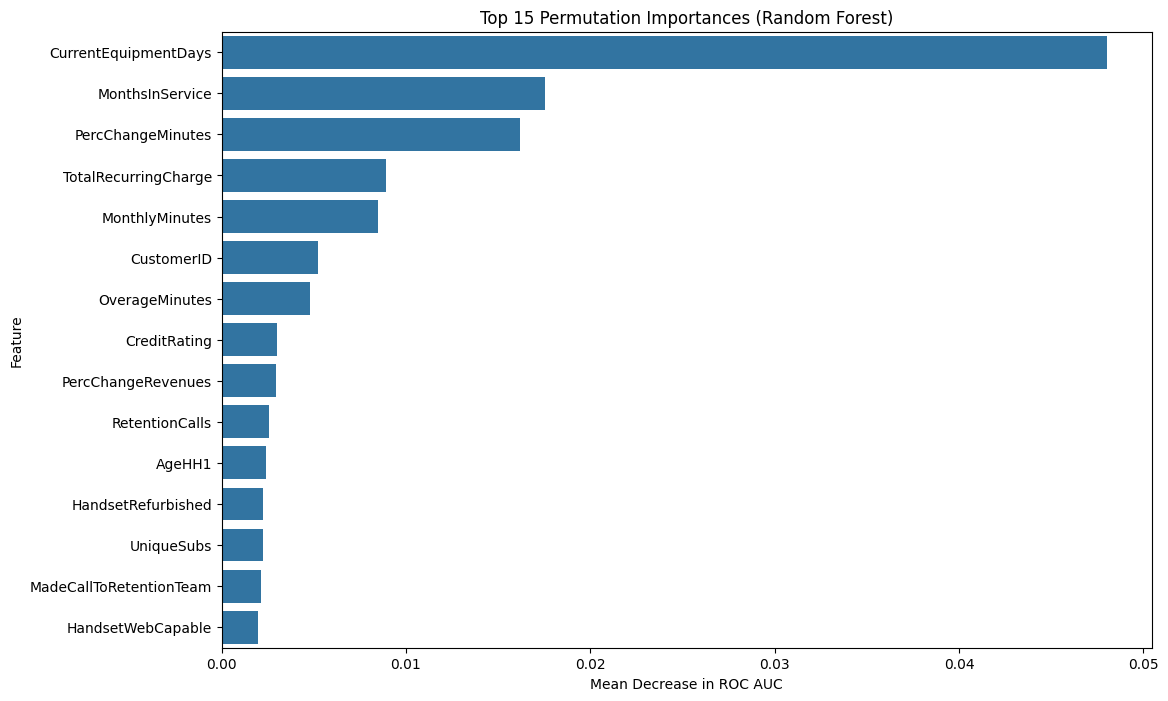

In [156]:
# Visualize the permutation importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance_mean', y='feature', data=permutation_importance_df.head(15))
plt.title('Top 15 Permutation Importances (Random Forest)')
plt.xlabel('Mean Decrease in ROC AUC')
plt.ylabel('Feature')
plt.show()

### Final Model Selection And Confusion Matrix


Random Forest Evaluation:
ROC AUC: 0.6625
              precision    recall  f1-score   support

           0       0.72      0.99      0.83     10901
           1       0.67      0.03      0.06      4414

    accuracy                           0.72     15315
   macro avg       0.69      0.51      0.45     15315
weighted avg       0.70      0.72      0.61     15315



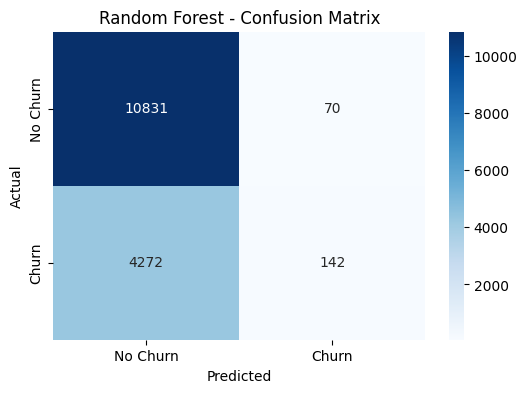


Naive Bayes Evaluation:
ROC AUC: 0.5736
              precision    recall  f1-score   support

           0       0.74      0.71      0.73     10901
           1       0.35      0.38      0.36      4414

    accuracy                           0.62     15315
   macro avg       0.55      0.55      0.55     15315
weighted avg       0.63      0.62      0.62     15315



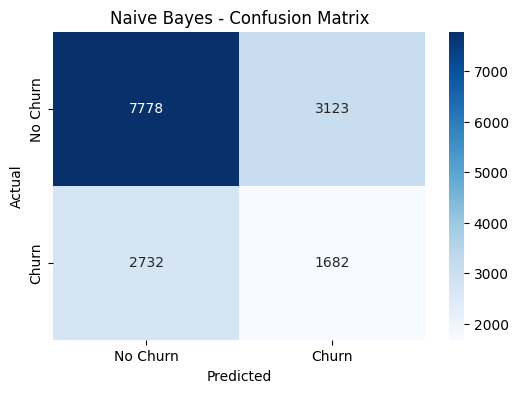


Best Model Selected: Random Forest


In [157]:
# Confusion Matrix  (Selecting Best Model)
from sklearn.metrics import confusion_matrix
def evaluate_model(name, model, X_test, y_test):
    y_probs = model.predict_proba(X_test)[:, 1]
    y_preds = (y_probs >= 0.5).astype(int)

    print(f"\n{name} Evaluation:")
    print(f"ROC AUC: {roc_auc_score(y_test, y_probs):.4f}")
    print(classification_report(y_test, y_preds))

    cm = confusion_matrix(y_test, y_preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Evaluate both models
evaluate_model("Random Forest", best_rf_model_tuned, X_test, y_test)
evaluate_model("Naive Bayes", nb_model, X_test, y_test)

# Compare AUC
rf_auc = roc_auc_score(y_test, best_rf_model_tuned.predict_proba(X_test)[:, 1])
nb_auc = roc_auc_score(y_test, nb_model.predict_proba(X_test)[:, 1])
best_model_name = "Random Forest" if rf_auc > nb_auc else "Naive Bayes"
print(f"\nBest Model Selected: {best_model_name}")

# Conclusion
- In this churn prediction analysis using the Cell2Cell dataset, a variety of machine learning models were explored to identify high-risk customers and support proactive retention strategies. After thorough experimentation and cross-validation, `Random Forest emerged as the most effective model`, delivering a strong balance between predictive accuracy, robustness, and interpretability.
- Key features driving churn included TenureMonths, MonthlyRevenue, CustomerCareCalls, and HandsetPrice, with Random Forest offering reliable feature importance rankings and resilience to noisy data. Its ensemble structure allowed for capturing complex, nonlinear relationships without excessive tuning.
- The final model achieved stable results across folds, with high recall for the churn class—crucial for minimizing false negatives in business applications. This approach equips telecom operators with a scalable and interpretable solution to reduce churn and retain valuable customers.
- The entire pipeline supports offline deployment and future scaling, aligning perfectly with real-world business needs and model lifecycle management.

- Random Forest Classifier ROC AUC: `0.6625`
- Navie Bayes Classifier ROC AUC: `0.5736`